# Image Optimization
Gradient based image optimization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
from models import alexnet_wrapper
import xforms


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
def norm_image(x):
    """
    Scales image values to [0, 1]
    """
    
    return (x - np.min(x))/np.ptp(x)

### Set up tensorflow graph

In [4]:
params = {
    'regularization_scale': 1e-4,
    'learning_rate': 0.05,
}

In [5]:
CHECKPOINT_PATH = 'checkpoints/model.ckpt-115000'

In [6]:
NUM_STEPS = 64

#### Initialize image as random noise

In [7]:
image_initializer = tf.random_uniform_initializer(
    minval=0,
    maxval=1,
)

image_regularizer = tf.contrib.layers.l2_regularizer(
    scale=params['regularization_scale']
)

image_shape = (1, 128, 128, 3)
images = tf.get_variable(
    "images",
    image_shape,
    initializer=image_initializer,
    regularizer=image_regularizer)
    
print(images)

Instructions for updating:
Colocations handled automatically by placer.
<tf.Variable 'images:0' shape=(1, 128, 128, 3) dtype=float32_ref>


#### do preprocessing here

In [8]:
scales = [1 + (i - 5) / 50. for i in range(11)]
angles = list(range(-10, 11)) + 5 * [0]
print(scales)
print(angles)

[0.9, 0.92, 0.94, 0.96, 0.98, 1.0, 1.02, 1.04, 1.06, 1.08, 1.1]
[-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 0, 0, 0, 0]


In [9]:
images = xforms.pad(images, pad_amount=12)
images = xforms.jitter(images, jitter_amount=8)
images = xforms.random_scale(images, scales)
images = xforms.random_rotate(images, angles)
images = xforms.jitter(images, jitter_amount=4)

#### get tensor we want to optimize

In [10]:
tensor_name = 'conv_3' # this is the 4th conv layer of alexnet
model_output = alexnet_wrapper(
    images,
    tensor_name=tensor_name,
    train=False
)

print(model_output)

Tensor("conv_3:0", shape=(1, ?, ?, 384), dtype=float32)


#### specify loss to minimize
In this example, I'm going to optimize for high activity for a single unit:
(x, y) = (4, 4)
channel = 1

(and add regularization)

In [11]:
total_regularization = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
loss = tf.negative(model_output[:, 4, 4, 1]) + total_regularization
print(loss)

Tensor("add_2:0", shape=(1,), dtype=float32)


#### now we need to minimize the loss

In [12]:
variables_to_train = [var for var in tf.trainable_variables() if "images:0" == var.name]
print(variables_to_train)

[<tf.Variable 'images:0' shape=(1, 128, 128, 3) dtype=float32_ref>]


In [13]:
optimizer = tf.train.AdamOptimizer(params['learning_rate'])
train_op = optimizer.minimize(loss, var_list=variables_to_train)

#### create a Session and restore model weights

In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [15]:
all_variables = tf.get_collection_ref(tf.GraphKeys.GLOBAL_VARIABLES)
saver = tf.train.Saver(
    var_list=[v for v in all_variables if "images" not in v.name and "beta" not in v.name]
)
saver.restore(sess, CHECKPOINT_PATH)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt-115000


In [16]:
loss_list = list()
image_list = list()

for step in range(NUM_STEPS):
    loss_list.append(sess.run(loss))
    image_list.append(norm_image(sess.run(images)))
    sess.run(train_op)

#### Plot outputs

Text(0.5, 0, 'Steps')

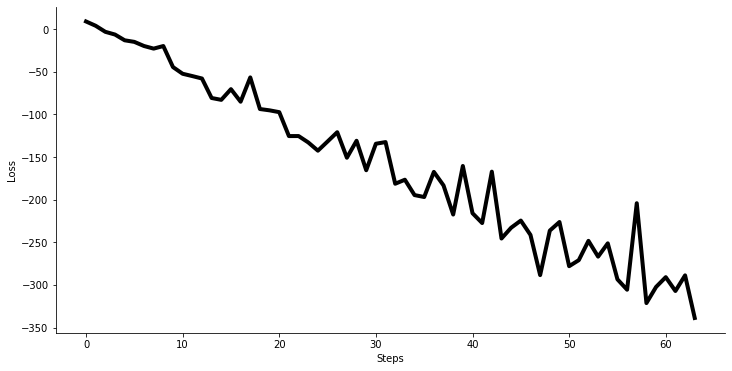

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(loss_list, c='k', linewidth=4)

# plot formatting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Loss')
ax.set_xlabel('Steps')


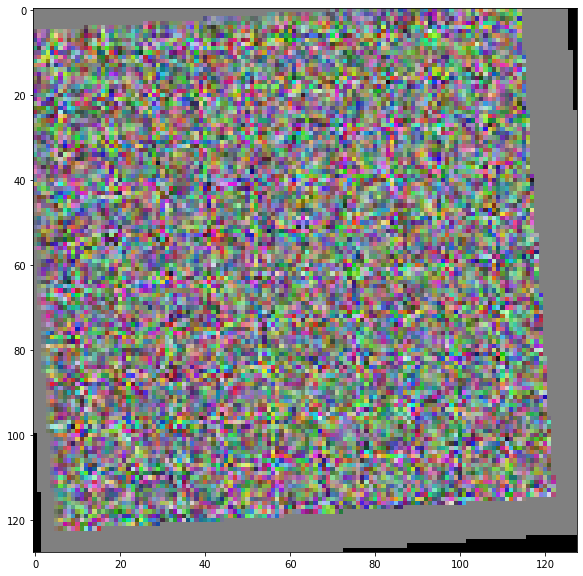

In [18]:
from matplotlib import animation
from IPython.display import HTML

plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript

fig, ax = plt.subplots(figsize=(10, 10))
l = ax.imshow(np.zeros((128, 128, 3)))

def animate(i):
    l.set_data(np.squeeze(image_list[i]))

ani = animation.FuncAnimation(fig, animate, frames=NUM_STEPS)
ani